In [2]:
# Made by Natalie Allen 10/07/2021
# basic TAP queries and plotting with hover annotations

# all confirmed planets
#! wget "https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+*+from+ps&format=csv" -O "confirmed_planets.csv"

# all confirmed transiting planets
#! wget "https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+*+from+ps+where+tran_flag+=+1+and+default_flag+=+1+order+by+pl_name+desc+&format=csv" -O "transit_confirmed_planets.csv"

# transiting planets with mass
# ! wget "https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+*+from+ps+where+tran_flag+=+1+and+default_flag+=+1+and+pl_masse+>+0.+order+by+pl_name+desc+&format=csv" -O "tsm_transit_confirmed_planets.csv"

# nearby (<75 pc) transiting planets with mass
! wget "https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+*+from+ps+where+tran_flag+=+1+and+default_flag+=+1+and+pl_masse+>+0.+and+sy_dist+<+75.+order+by+pl_name+desc+&format=csv" -O "nearby_tsm_transit_confirmed_planets.csv"



--2021-10-07 20:49:08--  https://exoplanetarchive.ipac.caltech.edu/TAP/sync?query=select+*+from+ps+where+tran_flag+=+1+and+default_flag+=+1+and+pl_masse+%3E+0.+and+sy_dist+%3C+75.+order+by+pl_name+desc+&format=csv
Resolving exoplanetarchive.ipac.caltech.edu (exoplanetarchive.ipac.caltech.edu)... 134.4.54.151
Connecting to exoplanetarchive.ipac.caltech.edu (exoplanetarchive.ipac.caltech.edu)|134.4.54.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/plain]
Saving to: ‘nearby_tsm_transit_confirmed_planets.csv’

nearby_tsm_transit_     [    <=>             ] 429.49K   455KB/s    in 0.9s    

2021-10-07 20:49:10 (455 KB/s) - ‘nearby_tsm_transit_confirmed_planets.csv’ saved [439801]



In [3]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
import mplcursors

import seaborn as sb
sb.set_context("talk")

In [4]:
planets = pd.read_csv("confirmed_planets.csv")
t_planets = pd.read_csv("transit_confirmed_planets.csv")
tsm_planets = pd.read_csv("tsm_transit_confirmed_planets.csv")
near_tsm_planets = pd.read_csv("nearby_tsm_transit_confirmed_planets.csv")

/Users/natalieallen/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (50,148,153,183,187,206,211,237,242) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
# columns: https://exoplanetarchive.ipac.caltech.edu/docs/API_PS_columns.html
print(t_planets.columns.values)

['pl_name' 'pl_letter' 'hostname' 'hd_name' 'hip_name' 'tic_id' 'gaia_id'
 'default_flag' 'pl_refname' 'sy_refname' 'disc_pubdate' 'disc_year'
 'discoverymethod' 'disc_locale' 'disc_facility' 'disc_instrument'
 'disc_telescope' 'disc_refname' 'ra' 'rastr' 'dec' 'decstr' 'glon' 'glat'
 'elon' 'elat' 'pl_orbper' 'pl_orbpererr1' 'pl_orbpererr2' 'pl_orbperlim'
 'pl_orbperstr' 'pl_orblpererr1' 'pl_orblper' 'pl_orblpererr2'
 'pl_orblperlim' 'pl_orblperstr' 'pl_orbsmax' 'pl_orbsmaxerr1'
 'pl_orbsmaxerr2' 'pl_orbsmaxlim' 'pl_orbsmaxstr' 'pl_orbincl'
 'pl_orbinclerr1' 'pl_orbinclerr2' 'pl_orbincllim' 'pl_orbinclstr'
 'pl_orbtper' 'pl_orbtpererr1' 'pl_orbtpererr2' 'pl_orbtperlim'
 'pl_orbtperstr' 'pl_orbeccen' 'pl_orbeccenerr1' 'pl_orbeccenerr2'
 'pl_orbeccenlim' 'pl_orbeccenstr' 'pl_eqt' 'pl_eqterr1' 'pl_eqterr2'
 'pl_eqtlim' 'pl_eqtstr' 'pl_occdep' 'pl_occdeperr1' 'pl_occdeperr2'
 'pl_occdeplim' 'pl_occdepstr' 'pl_insol' 'pl_insolerr1' 'pl_insolerr2'
 'pl_insollim' 'pl_insolstr' 'pl_dens' 'pl_

In [7]:
print(tsm_planets["pl_name"])

0         pi Men c
1           XO-7 b
2           XO-6 b
3           XO-5 b
4           XO-4 b
          ...     
884      CoRoT-1 b
885    BD+20 594 b
886       AU Mic c
887       AU Mic b
888       55 Cnc e
Name: pl_name, Length: 889, dtype: object


In [9]:
# setting scales according to Kempton et al. 2018 for TSM metric
# 0.190 1.26 1.28 1.15
def scales(rp):
    if rp["pl_rade"] < 1.50:
        return 0.190
    if 1.50 < rp["pl_rade"] < 2.75:
        return 1.26
    if 2.75 < rp["pl_rade"] < 4.0:
        return 1.28
    if rp["pl_rade"] > 4.0:
        return 1.15

In [10]:
# creating scale column in df
near_tsm_planets["scale"] = near_tsm_planets.apply(lambda row: scales(row), axis=1)

In [11]:
# tsm calculating functions
# tap columns for params: pl_rade (earth radii) , pl_eqt, pl_masse (earth masses), st_rad, sy_jmag
def tsm(scale, rp, teq, mp, rs, mj):
    return scale*(rp**3 * teq)/(mp * rs**2) * 10**(-mj/5)

def tsm_pds(row):
    return row["scale"]*(row["pl_rade"]**3 * row["pl_eqt"])/(row["pl_masse"] * row["st_rad"]**2) * 10**(-row["sy_jmag"]/5)

In [12]:
# creating tsm column in df
near_tsm_planets["TSM"] = near_tsm_planets.apply(lambda row: tsm_pds(row), axis=1)

<IPython.core.display.Javascript object>


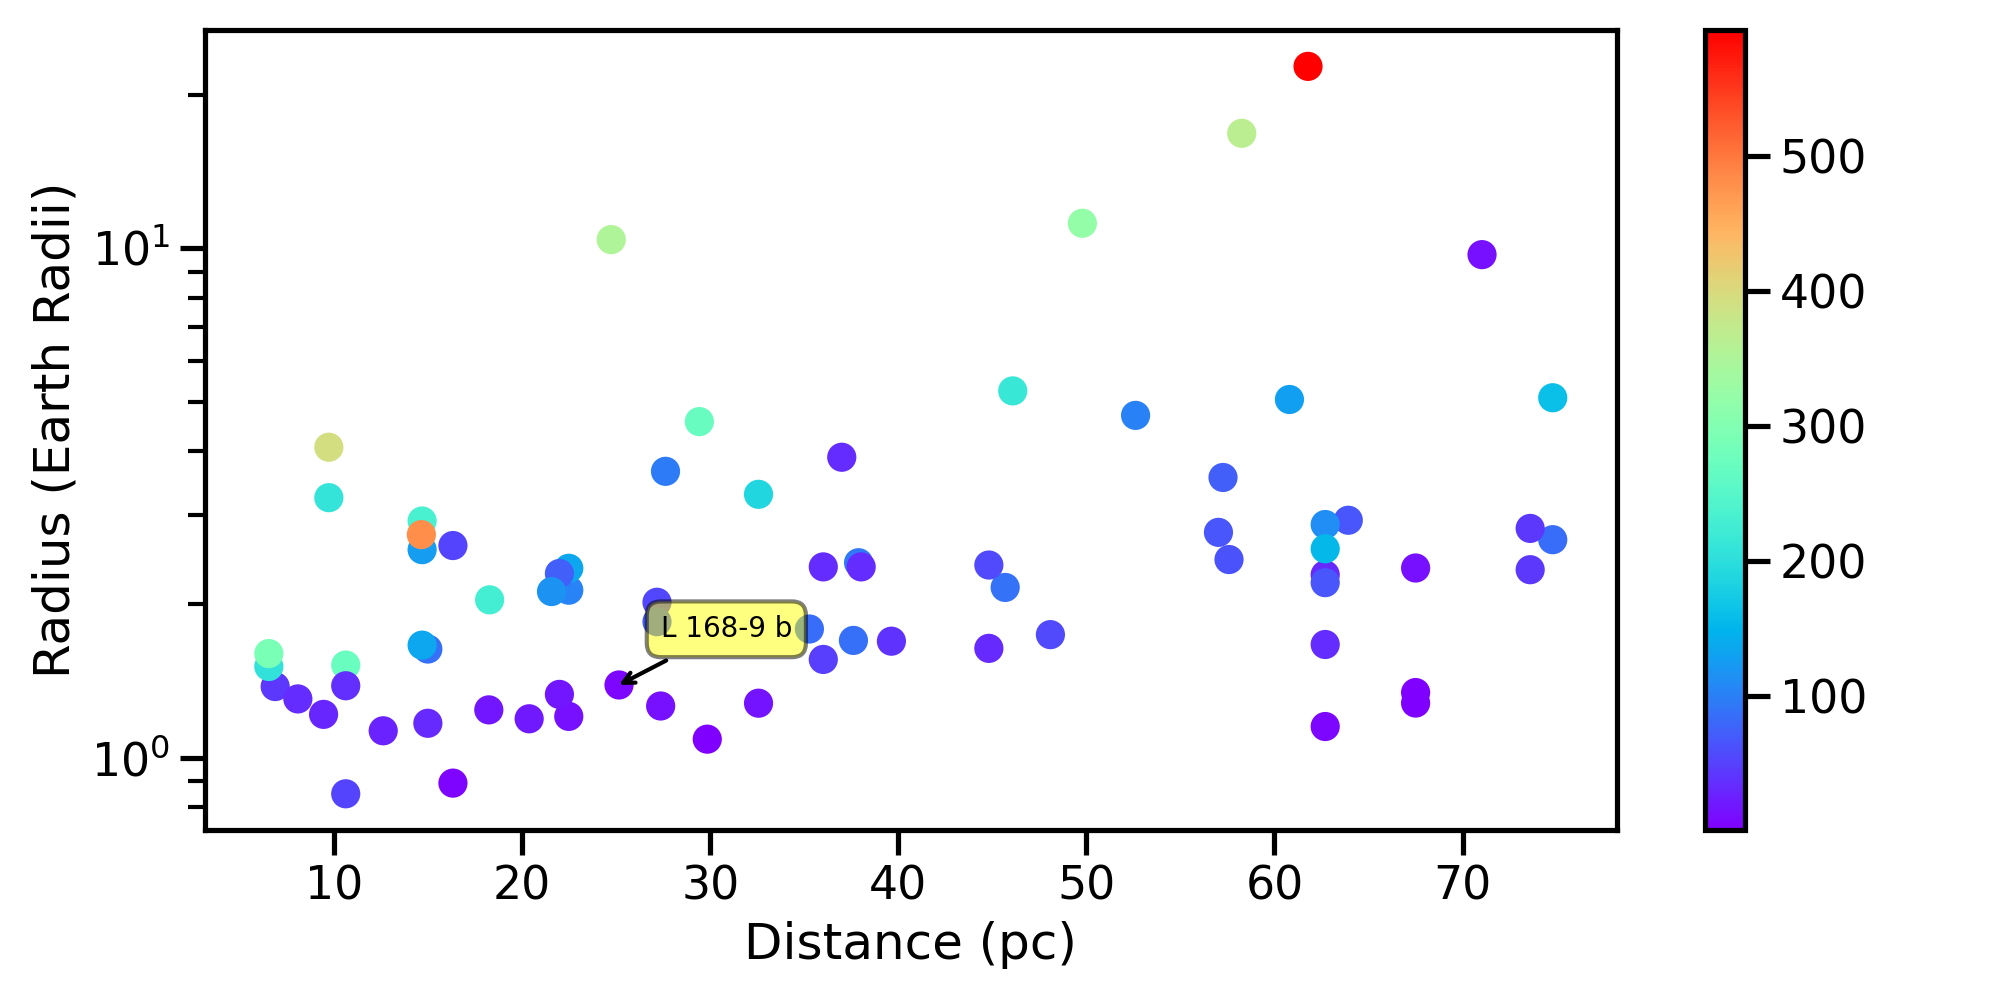

In [67]:
# need to be in %matplotlib notebook for the hover annotations to work
%matplotlib notebook
color = "rainbow"
fig, ax = plt.subplots(1, figsize=(10,5))

# can  set x, y, c = colorbar parameters to be whatever, and the tt parameter sets the hover annotation
x = near_tsm_planets["sy_dist"]
y = near_tsm_planets["pl_rade"]
tt = near_tsm_planets["pl_name"].values
c = near_tsm_planets["TSM"]

p = ax.scatter(x, y, c=c, cmap = color)

norm = plt.Normalize(c.min(), c.max())
sm = plt.cm.ScalarMappable(cmap=color, norm=norm)
sm.set_array([])
p.figure.colorbar(sm)

ax.set_yscale('log')

# setting the hover annotations - if you don't want this/don't want to install mplcursors just comment the next few lines
cursor = mplcursors.cursor(p, hover=True)

@cursor.connect("add")
def on_add(sel):
    sel.annotation.set(text=tt[sel.target.index])
    
ax.set_ylabel("Radius (Earth Radii)")
ax.set_xlabel("Distance (pc)")
plt.tight_layout()
plt.show()